# Analyses of reconstruction error


### "Do circle-reconstructions differ as a function of distance to the gaussian center?"


In [1]:
import torch
import pickle

import sys
sys.path.append("..") # Adds higher directory to python modules path.

import matplotlib.pyplot as plt
import numpy as np

use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")

from torchvision import transforms
from data.dspritesb import dSpriteBackgroundDataset
ds = dSpriteBackgroundDataset(transform=transforms.Resize((32,32)),shapetype = 'circle')

In [2]:
from matplotlib.colors import Normalize
from matplotlib import cm
from scipy.stats import gaussian_kde as kde

# makeColours creates colors each point in a set of points (2D) based on their estimated density
# insideCircleErrorByDist.shape -> [N, 2]
# densObj0 = kde( insideCircleErrorByDist.T )
# cols0 = makeColours(densObj0.evaluate(insideCircleErrorByDist.T))

def makeColours( vals ):
    colours = np.zeros( (len(vals),3) )
    norm = Normalize( vmin=vals.min(), vmax=vals.max() )
    colours = [cm.ScalarMappable( norm=norm, cmap='viridis').to_rgba( val ) for val in vals]
    return colours

### model: staticVAE32 (standard VAE)


In [3]:
from staticvae.models import staticVAE32

vae = staticVAE32(n_latent = 4)
vae.eval()
checkpoint = torch.load('../staticvae/trained/staticvae32_dsprites_circle_last_500K')
vae.load_state_dict(checkpoint['model_states']['net'])

training_stats = pickle.load(open('../staticvae/trained/staticvae32_dsprites_circle_500K.pkl', 'rb'))

### first, simply display some reconstructions

random samples from the datasets, their reconstructions, and the difference between the two

/home/benjamin/anaconda3/envs/deepl10/lib/python3.7/site-packages/torch/nn/functional.py:1332: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


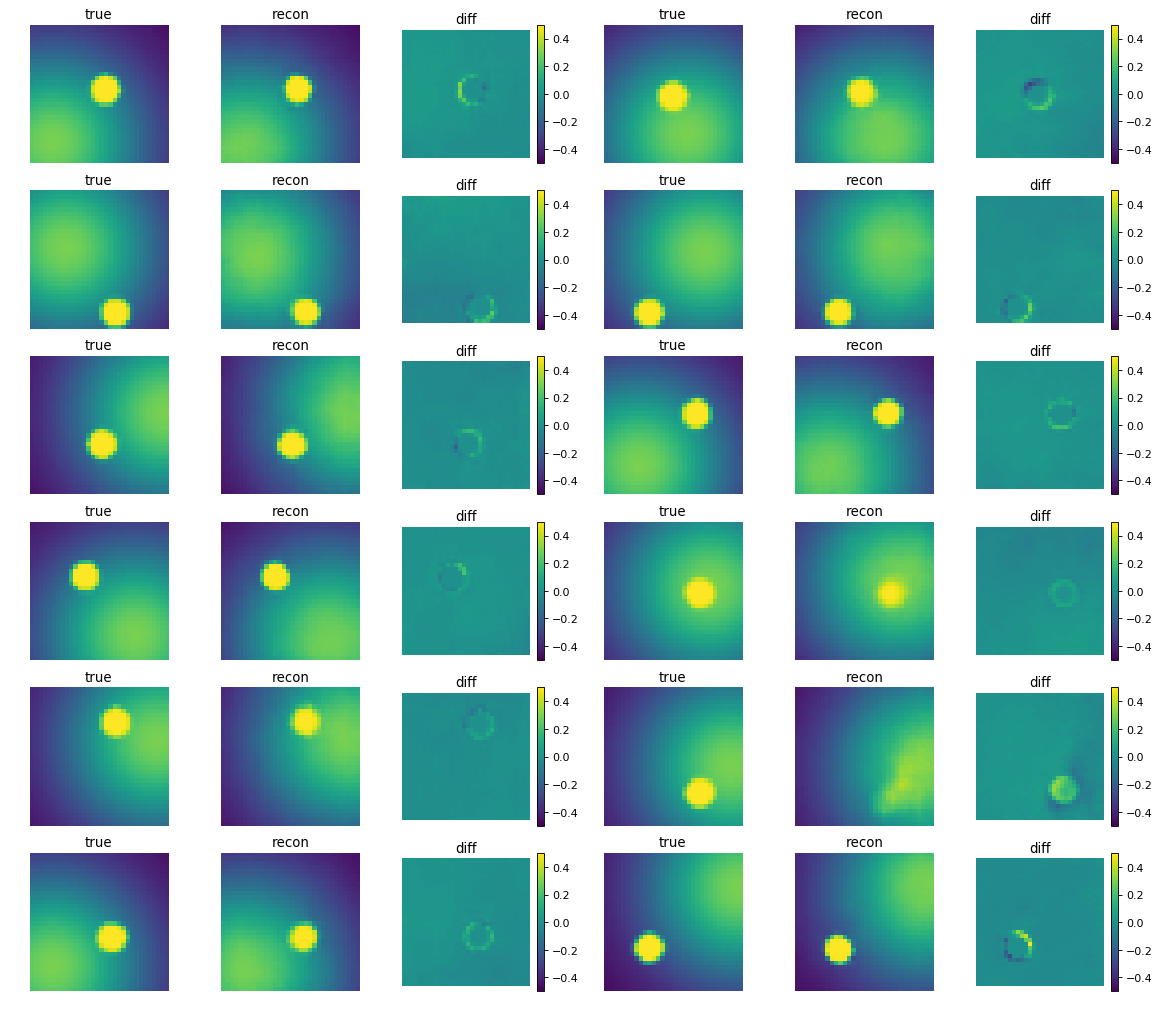

In [4]:
fig=plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')
cnt = 0
for ii in range(12):
    x,label = ds[np.random.randint(1000)]
    x = x[np.newaxis, :, :]
    
    recon, mu, logvar = vae(x.float())
    recon = recon.detach()
    diff = x - recon
    
    cnt += 1
    ax = plt.subplot(6,6,cnt)
    ax.imshow(x.squeeze(), vmin=0, vmax=1)
    plt.title('true')
    plt.axis('off')
    
    cnt += 1
    ax = plt.subplot(6,6,cnt)    
    ax.imshow(recon.squeeze(), vmin=0, vmax=1)
    plt.title('recon')
    plt.axis('off')
    
    cnt += 1
    ax = plt.subplot(6,6,cnt)    
    m = .5
    img = ax.imshow(diff.numpy().squeeze(), vmin=-m, vmax=m)
    fig.colorbar(img)
    plt.title('diff')
    plt.axis('off')
    

### Testing the masking function (getCircleSegmentationMasks) of the dSpriteBackgroundDataset class

this is not part of the analysis, but to demonstrate what "inside circle", "edge of circle", and "background" refers to in the following analysis. 

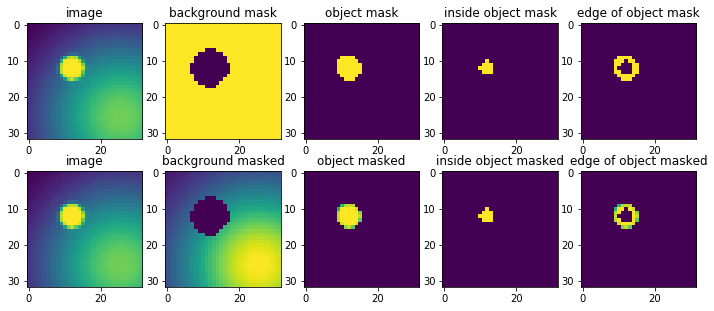

In [5]:
def plotImageAndItsSegmentations(ds, objx=.34,objy=.34,backx=.8,backy=.8):

    x = ds.arbitraryCircle(objx, objy, backx, backy)
    backgroundMask, objectMask, insideObjectMask, objectEdgeMask = ds.getCircleSegmentationMasks(objx,objy)

    #objectMask = ds.arbitraryCircle(objx, objy, backx = None, backy = None, radius = .1) > .4
    
    _,ax = plt.subplots(2,5, figsize = (12, 5))
    ax[0,0].imshow(x.squeeze())
    ax[0,1].imshow(backgroundMask.squeeze())
    ax[0,2].imshow(objectMask.squeeze())
    ax[0,3].imshow(insideObjectMask.squeeze())
    ax[0,4].imshow(objectEdgeMask.squeeze())


    ax[1,0].imshow(x.squeeze())
    xt = torch.zeros_like(x)
    xt[backgroundMask] = x[backgroundMask]
    ax[1,1].imshow(xt.squeeze())
    xt = torch.zeros_like(x)
    xt[objectMask] = x[objectMask]
    ax[1,2].imshow(xt.squeeze())
    xt = torch.zeros_like(x)
    xt[insideObjectMask] = x[insideObjectMask]
    ax[1,3].imshow(xt.squeeze())
    xt = torch.zeros_like(x)
    xt[objectEdgeMask] = x[objectEdgeMask]
    ax[1,4].imshow(xt.squeeze())

    ax[0,0].set_title('image')
    ax[0,1].set_title('background mask')
    ax[0,2].set_title('object mask')
    ax[0,3].set_title('inside object mask')
    ax[0,4].set_title('edge of object mask')
    ax[1,0].set_title('image')
    ax[1,1].set_title('background masked')
    ax[1,2].set_title('object masked')
    ax[1,3].set_title('inside object masked')
    ax[1,4].set_title('edge of object masked')

plotImageAndItsSegmentations(ds)

### Plot reconstruction error for object, edge of object, background for different configurations of object and background

#### compute errors

loop across an equidistantly spaced 4D grid (objx,objy,backx,backy) and compute reconstruction error for each of the samples


In [7]:
x_ = np.linspace(0, 1., 8)
y_ = np.linspace(0, 1., 8)
X, Y = np.meshgrid(x_,y_)
n_xg = len(x_)
n_yg = len(y_)

# reconstruction error by x,y of gaussian and x,y of circle
insideCircleError = np.zeros((n_xg,n_yg,n_xg,n_yg))
edgeCircleError = np.zeros((n_xg,n_yg,n_xg,n_yg))
backgroundError = np.zeros((n_xg,n_yg,n_xg,n_yg))

# will contain a list of [distance_between_circle_and_gaussian, recon_error] paris
insideCircleErrorByDist = np.zeros((np.prod([n_xg,n_yg,n_xg,n_yg]),2))
edgeCircleErrorByDist = np.zeros((np.prod([n_xg,n_yg,n_xg,n_yg]),2))
backgroundErrorByDist = np.zeros((np.prod([n_xg,n_yg,n_xg,n_yg]),2))

cnt = 0
for ixgauss, x_gauss in enumerate(x_):
    for iygauss, y_gauss in enumerate(y_):
        
        for ixcirc, x_circ in enumerate(x_):
            for iycirc, y_circ in enumerate(y_):
                
                x = ds.arbitraryCircle(objx = x_circ, objy = y_circ, backx = x_gauss, backy = y_gauss)
                mu,_ = vae.encode(x)    
                recon = vae.decode(mu)
                               
                backgroundMask, objectMask, insideObjectMask, objectEdgeMask = ds.getCircleSegmentationMasks(x_circ,y_circ)
                
                err = torch.pow(x - recon,2)
                
                insideCircleError[ixgauss,iygauss,ixcirc,iycirc] = torch.mean(err[insideObjectMask])
                edgeCircleError[ixgauss,iygauss,ixcirc,iycirc] = torch.mean(err[objectEdgeMask])
                backgroundError[ixgauss,iygauss,ixcirc,iycirc] = torch.mean(err[backgroundMask])
                
                actdist = np.sqrt((x_gauss-x_circ)**2 + (y_gauss-y_circ)**2)
                insideCircleErrorByDist[cnt,0] = actdist
                insideCircleErrorByDist[cnt,1] = insideCircleError[ixgauss,iygauss,ixcirc,iycirc]
                backgroundErrorByDist[cnt,0] = actdist
                backgroundErrorByDist[cnt,1] = backgroundError[ixgauss,iygauss,ixcirc,iycirc]
                edgeCircleErrorByDist[cnt,0] = actdist
                edgeCircleErrorByDist[cnt,1] = edgeCircleError[ixgauss,iygauss,ixcirc,iycirc]
                
                cnt += 1


#### do reconstruction errors differ for the circle and background?

i.e., errors differ between background, inside of object, and edge of object

Text(0.5, 1.0, 'mean and std of recon error (different scale on y-axis)')

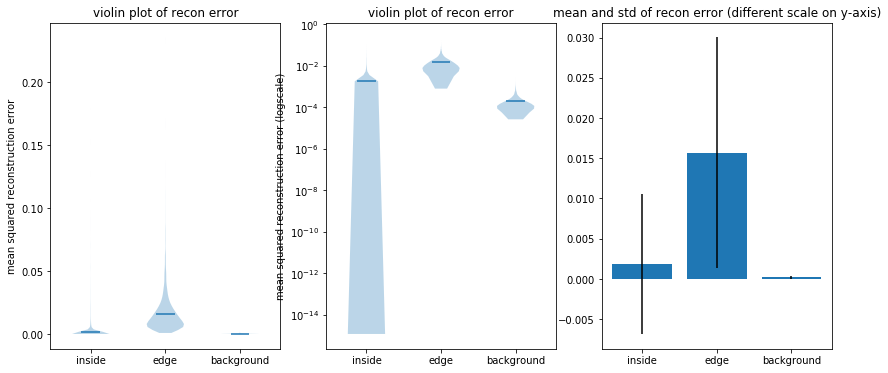

In [8]:
#np.mean(insideCircleError, axis=(2,3),keepdims=True).shape
stackedErrors = np.vstack((insideCircleError.flatten(),
                     edgeCircleError.flatten(),
                     backgroundError.flatten())).T

_,ax = plt.subplots(1,3,figsize=(14,6),sharey=False, sharex=True)

ax[0].violinplot(stackedErrors,
             showextrema=False, showmeans=True)
ax[0].set(xticks=[1.,2.,3.],xticklabels=('inside', 'edge', 'background'))
ax[0].set(ylabel='mean squared reconstruction error')
ax[0].set_title('violin plot of recon error')

ax[1].violinplot(stackedErrors,
             showextrema=False, showmeans=True)
ax[1].set(xticks=[1.,2.,3.],xticklabels=('inside', 'edge', 'background'))
ax[1].set(ylabel='mean squared reconstruction error (logscale)')
ax[1].set_title('violin plot of recon error')
ax[1].set(yscale='log')

ax[2].bar([1.,2.,3.],np.mean(stackedErrors, axis=0), yerr=np.std(stackedErrors, axis=0))
ax[2].set_title('mean and std of recon error (different scale on y-axis)')

... yes, they do. Edge reconstructions are substantially worse than inside circle or background (almost no error).

#### images with large reconstruction errors for the circle are ...

first, plot some reconstructions with the largest reconstruction error samples (5 left plots with corresponding reconstruction errors) as well as the best reconstructions (5 right plots)

Text(0.5, 0.98, 'worst (left halft) and best (right half) reconstructions when reconstruction error is computed for ...')

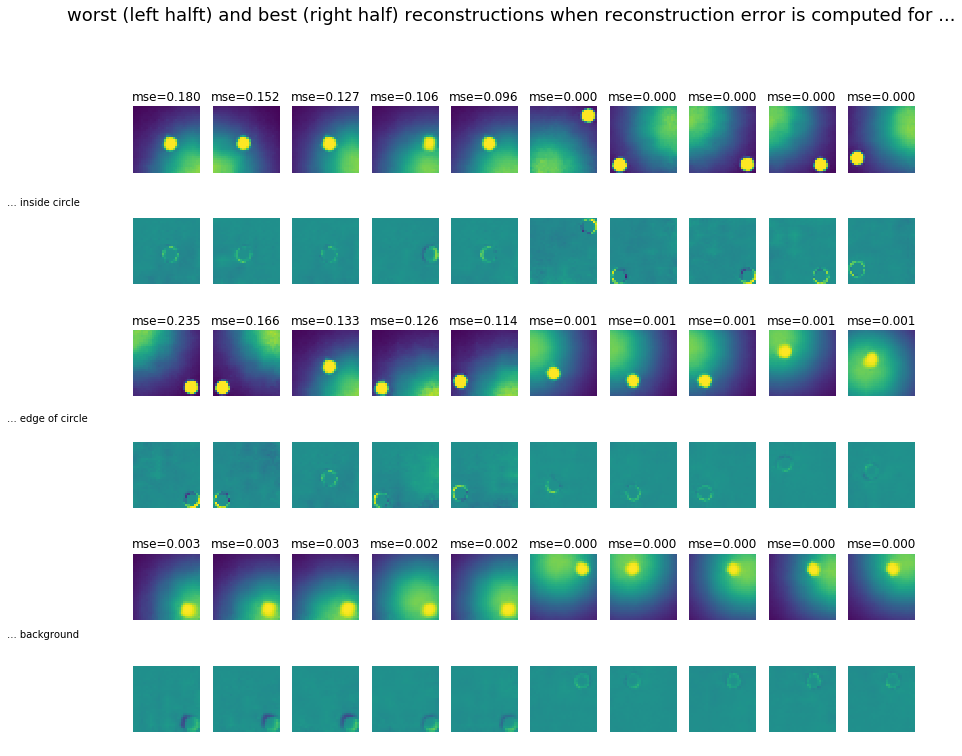

In [9]:
listOfErrors = list((insideCircleError, edgeCircleError, backgroundError))

fig,axes=plt.subplots(6,10, figsize=(14,12))

tx = ('inside circle', 'edge of circle', 'background')

for jj in range(3): # loop across the three different masking regions

    sortedIdx = np.argsort(listOfErrors[jj],axis=None)
    
    for ii,ax in enumerate(axes[jj*2:jj*2+2,:5].T.tolist()): # loop across worst examples

        c0,c1,c2,c3 = np.unravel_index(sortedIdx[-(ii+1)], listOfErrors[jj].shape)

        x = ds.arbitraryCircle(objx = x_[c0], objy = y_[c1], backx = x_[c2], backy = x_[c3])
        mu,_ = vae.encode(x)    
        recon = vae.decode(mu)

        ax[0].imshow(recon.detach().squeeze(),vmin=0,vmax=1)
        ax[0].axis('off')
        ax[0].set(title='mse=%0.3f' % listOfErrors[jj][c0,c1,c2,c3])
        
        ax[1].imshow((x-recon).detach().squeeze(),vmin=-.5,vmax=.5)
        ax[1].axis('off')

    for ii,ax in enumerate(axes[jj*2:jj*2+2,5:].T.tolist()): # loop across best examples

        c0,c1,c2,c3 = np.unravel_index(sortedIdx[ii], listOfErrors[jj].shape)

        x = ds.arbitraryCircle(objx = x_[c0], objy = y_[c1], backx = x_[c2], backy = x_[c3])
        mu,_ = vae.encode(x)    
        recon = vae.decode(mu)

        ax[0].imshow(recon.detach().squeeze(),vmin=0,vmax=1)
        ax[0].axis('off')
        ax[0].set(title='mse=%0.3f' % listOfErrors[jj][c0,c1,c2,c3])
        
        ax[1].imshow((x-recon).detach().squeeze(),vmin=-.5,vmax=.5)
        ax[1].axis('off')
        
    fig.text(0., 0.75 - .25 * jj, '... %s' % tx[jj])

plt.suptitle('worst (left halft) and best (right half) reconstructions when reconstruction error is computed for ...', fontsize = 18)

#### systematic relationship of large circle reconstruction error and large background reconstruction error with distance between circle and gaussian

here, we plot the histogram of distances between gaussian and circle (as sampled on the grid above)

as overlay (in orange), the histogram of trials is plotted that have large reconstruction errors (95% percentile or above) for the inner part or the edge of the circle (left) or the background (right)

[Text(0, 0.5, 'density'),
 Text(0.5, 0, 'distances between circle and Gaussian')]

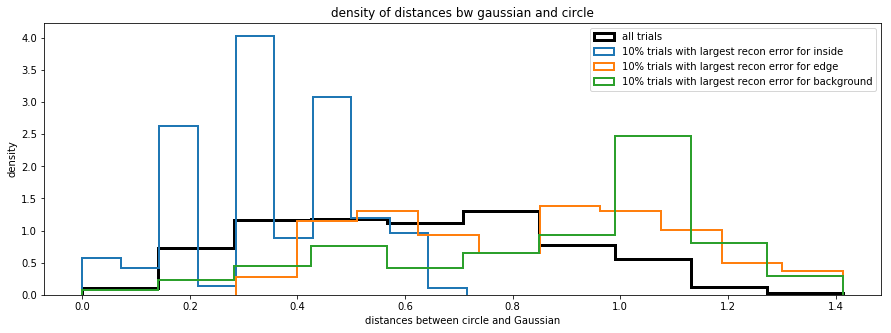

In [22]:
percentile = 90


_,ax=plt.subplots(1,1,figsize=(15,5))

# for the circle (inside and edge)
prcntlLargeReconError_inside = np.percentile(insideCircleErrorByDist[:,1], percentile)
prcntlLargeReconError_edge = np.percentile(edgeCircleErrorByDist[:,1], percentile)
prcntlLargeReconError_background = np.percentile(backgroundErrorByDist[:,1], percentile)

idx_largeReconErrorForInside = insideCircleErrorByDist[:,1] > prcntlLargeReconError_inside
idx_largeReconErrorForEdge = edgeCircleErrorByDist[:,1] > prcntlLargeReconError_edge
idx_largeReconErrorForBackground = backgroundErrorByDist[:,1] > prcntlLargeReconError_background

ax.hist(insideCircleErrorByDist[:,0], density=True, histtype='step', linewidth=3, color='k')
ax.hist(insideCircleErrorByDist[idx_largeReconErrorForInside,0], density=True, histtype='step', linewidth=2)
ax.hist(edgeCircleErrorByDist[idx_largeReconErrorForEdge,0], density=True, histtype='step', linewidth=2)
ax.hist(backgroundErrorByDist[idx_largeReconErrorForBackground,0], density=True, histtype='step', linewidth=2)
ax.legend(('all trials', '%d%% trials with largest recon error for inside' % (100-percentile), 
           '%d%% trials with largest recon error for edge' % (100-percentile), 
           '%d%% trials with largest recon error for background' % (100 -percentile)),loc=1)
ax.set_title('density of distances bw gaussian and circle')

ax.set(xlabel = 'distances between circle and Gaussian', ylabel='density')

#### a more detailed view on distance and reconstruction error

[Text(0.5, 0, 'distance bw circle and gauss')]

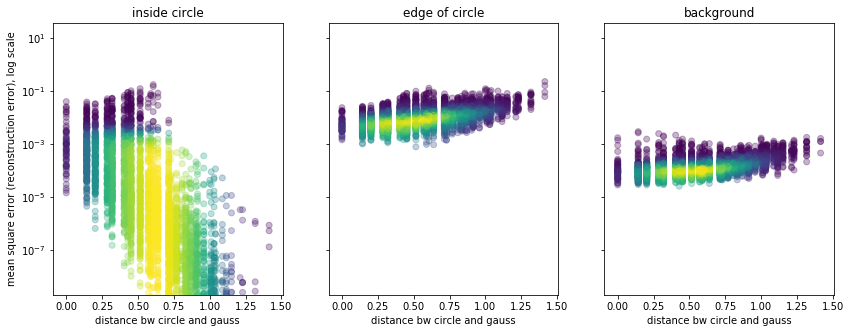

In [11]:
from matplotlib.colors import Normalize
from matplotlib import cm
from scipy.stats import gaussian_kde as kde

def makeColours( vals ):
    colours = np.zeros( (len(vals),3) )
    norm = Normalize( vmin=vals.min(), vmax=vals.max() )

    #Can put any colormap you like here.
    colours = [cm.ScalarMappable( norm=norm, cmap='viridis').to_rgba( val ) for val in vals]

    return colours

densObj0 = kde( insideCircleErrorByDist.T )
cols0 = makeColours(densObj0.evaluate(insideCircleErrorByDist.T))
densObj1 = kde( backgroundErrorByDist.T )
cols1 = makeColours(densObj1.evaluate(backgroundErrorByDist.T))
densObj2 = kde( edgeCircleErrorByDist.T )
cols2 = makeColours(densObj2.evaluate(edgeCircleErrorByDist.T))

_, axes = plt.subplots(1,3, sharey = True, sharex = True, figsize = (14,5))

axes[0].scatter(insideCircleErrorByDist[:,0], insideCircleErrorByDist[:,1], color=cols0, alpha = .3)
axes[0].set_title('inside circle')
axes[0].set(ylabel='mean square error (reconstruction error), log scale')
axes[0].set(xlabel='distance bw circle and gauss')
axes[0].set(yscale='log')

axes[2].scatter(backgroundErrorByDist[:,0], backgroundErrorByDist[:,1], color=cols1, alpha = .3)
axes[2].set_title('background')
axes[2].set(xlabel='distance bw circle and gauss')

axes[1].scatter(edgeCircleErrorByDist[:,0], edgeCircleErrorByDist[:,1], color=cols2, alpha = .3)
axes[1].set_title('edge of circle')
axes[1].set(xlabel='distance bw circle and gauss')


(note the log scale on the yaxis)

We see 
- for the inner circle: 
  - increased reconstruction error for close distances
  - very small reconstruction error for large distances.
- for the edge: 
  - the highest reconstruction errors overall
  - increasing errors at large distances (possibly the reconstruction error of the edge is masked at close distances as the edge color is very similar to the background color in that case)
  
We can also see
- a slight dependence between reconstruction error and distance for the background

